# 6.Layer & column digitization

This notebook demonstrates how to divide a predefined spatial area into layers and columns.

## Packages

In [1]:
import spateo as st
import dynamo as dyn

import numpy as np

import plotly.express as px

st.configuration.set_pub_style_mpltex()
%matplotlib inline

2022-11-13 22:52:29.181679: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


## Data source
**bin60_clustered_h5ad:** https://www.dropbox.com/s/wxgkim87uhpaz1c/mousebrain_bin60_clustered.h5ad?dl=0

**bin30_h5ad:** https://www.dropbox.com/s/tyvhndoyj8se5xt/mousebrain_bin30.h5ad?dl=0


In [2]:
# Load annotated binning data
fname_bin60 = "mousebrain_bin60_clustered.h5ad"
adata_bin60 = st.sample_data.mousebrain(fname_bin60)

# Load higher resolution binning data (optional)
fname_bin30 = "mousebrain_bin30.h5ad"
adata_bin30 = st.sample_data.mousebrain(fname_bin30)

adata_bin60, adata_bin30

(AnnData object with n_obs × n_vars = 7765 × 21667
     obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc', 'scc_anno'
     var: 'pass_basic_filter'
     uns: '__type', 'louvain', 'louvain_colors', 'neighbors', 'pp', 'scc', 'scc_anno_colors', 'scc_colors', 'spatial', 'spatial_neighbors'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
     layers: 'count', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances',
 AnnData object with n_obs × n_vars = 31040 × 25691
     obs: 'area'
     uns: '__type', 'pp', 'spatial'
     obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
     layers: 'count', 'spliced', 'unspliced')

## Data preparation

In [3]:
# Extract spatial domains from SCC clusters.
# Transfer domain annotation to higher resolution anndata object for better visualization (optional).
st.dd.set_domains(
    adata_high_res=adata_bin30,
    adata_low_res=adata_bin60,
    bin_size_high=30,
    bin_size_low=60,
    cluster_key="scc_anno",
    k_size=1.8,
    min_area=16,
)

|-----> Generate the cluster label image with `gen_cluster_image`.
|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
|-----> Iterate through each cluster and identify contours with `extract_cluster_contours`.
|-----> Get selected areas with label id(s): 13.
|-----> Close morphology of the area formed by cluster 13.
|-----> Remove small region(s).
|-----> Extract contours.
|-----> Get selected areas with label id(s): 7.
|-----> Close morphology of the area formed by cluster 7.
|-----> Remove small region(s).
|-----> Extract contours.
|-----> Get selected areas with label id(s): 5.
|-----> Close morphology of the area formed by cluster 5.
|-----> Remove small region(s).
|-----> Extract contours.
|-----> Get selected areas with label id(s): 1.
|-----> Close morphology of the area formed by cluster 1.
|-----> Re

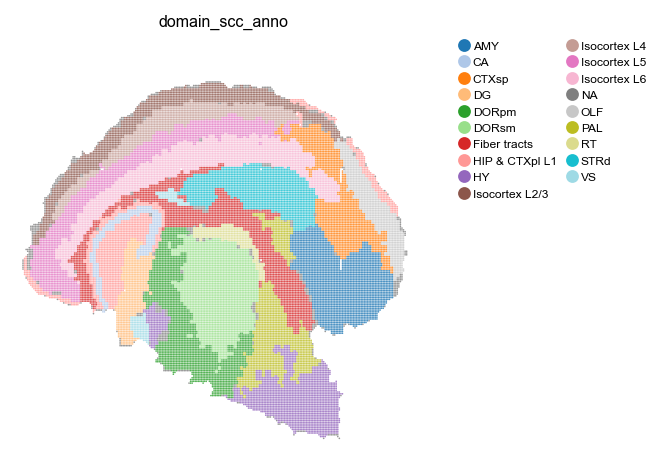

In [4]:
# Visualize transfered spatial domain
st.pl.space(
    adata_bin30,
    color=['domain_scc_anno'],
    show_legend="upper left",
    figsize=(4, 3.5),
    color_key_cmap="tab20",
)

## Extract region of interest

In [5]:
# Extract an area of interest
adata_bin30.obsm['spatial_bin30'] = adata_bin30.obsm['spatial']//30
cluster_label_image_lowres = st.dd.gen_cluster_image(adata_bin30, bin_size=1, spatial_key="spatial_bin30", cluster_key='domain_scc_anno', show=False)
cluster_label_list = np.unique(adata_bin30[adata_bin30.obs['domain_scc_anno'].isin(['Isocortex L4','Isocortex L5']), :].obs["cluster_img_label"])
contours, cluster_image_close, cluster_image_contour = st.dd.extract_cluster_contours(cluster_label_image_lowres, cluster_label_list, bin_size=1, k_size=6, show=False)

px.imshow(cluster_image_contour, width=500, height=500)

|-----> Set up the color for the clusters with the tab20 colormap.
|-----> Saving integer labels for clusters into adata.obs['cluster_img_label'].
|-----> Prepare a mask image and assign each pixel to the corresponding cluster id.
|-----> Get selected areas with label id(s): [11 12].
|-----> Close morphology of the area formed by cluster [11 12].
|-----> Remove small region(s).
|-----> Extract contours.


## Digitize the region of interest

In [6]:
# User input to specify a gridding direction
pnt_xY = (82,35)
pnt_xy = (91,39)
pnt_Xy = (171,172)
pnt_XY = (182,181)

# Digitize the area of interest
st.dd.digitize(
    adata=adata_bin30,
    ctrs=contours,
    ctr_idx=0,
    pnt_xy=pnt_xy,
    pnt_xY=pnt_xY,
    pnt_Xy=pnt_Xy,
    pnt_XY=pnt_XY,
    spatial_key="spatial_bin30"
)

|-----> Initialize the field of the spatial domain of interests.
|-----> Prepare the isoline segments with either the highest/lower column or layer heat values.
|-----> Solve the layer heat equation on spatial domain with the iso-layer-line conditions.
|-----> Total iteration: 890
|-----> Saving layer heat values to digital_layer.
|-----> Solve the column heat equation on spatial domain with the iso-column-line conditions.
|-----> Total iteration: 924
|-----> Saving column heat values to digital_column.


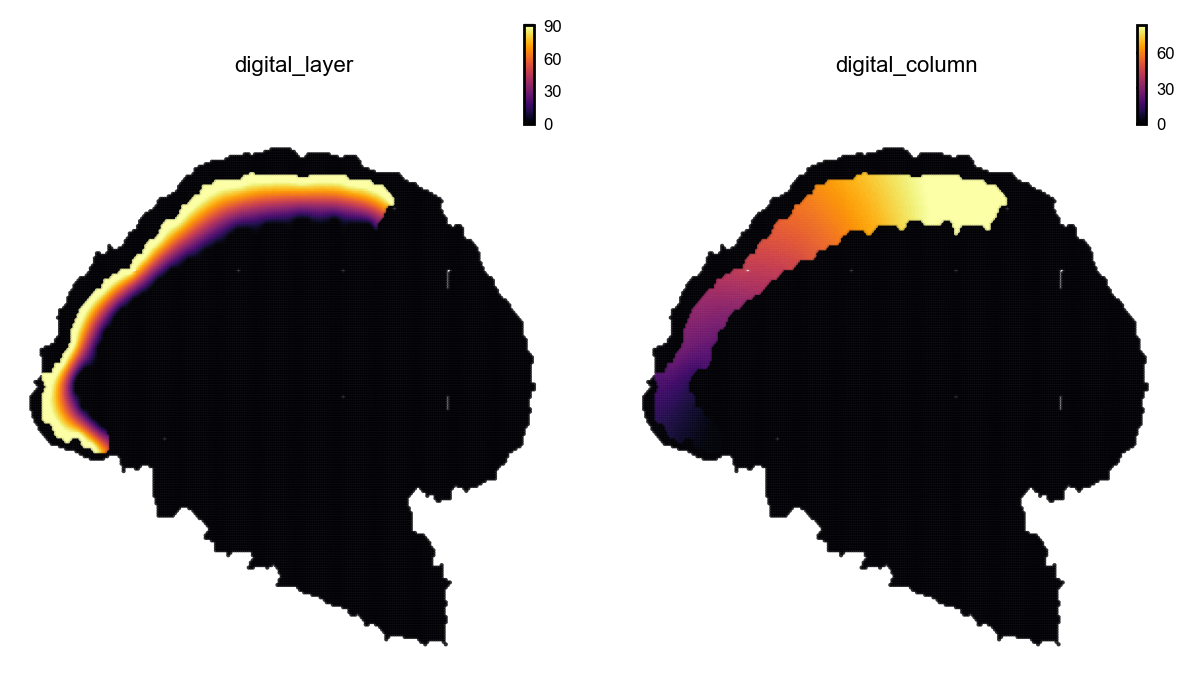

In [7]:
# Visualize digitized layers and columns
st.pl.space(
    adata_bin30,
    color=['digital_layer', 'digital_column'],
    ncols=2,
    pointsize=0.1,
    show_legend="upper left",
    figsize=(4, 3.5),
    color_key_cmap = "tab20",
)

## Identify variable genes along digitized columns with GLM

In [8]:
# Bin the digitized columns into larger columns
adata_bin30_l4l5 = adata_bin30[adata_bin30.obs['digital_column']!=0].copy()
adata_bin30_l4l5.obs['binned_column'] = adata_bin30_l4l5.obs['digital_column']//4

# Filter out low expressed genes and calculate GLM regression for each gene
st.pp.filter.filter_genes(adata_bin30_l4l5, min_cells=adata_bin30_l4l5.n_obs*0.05, inplace=True)
dyn.pp.normalize_cell_expr_by_size_factors(adata_bin30_l4l5)
dyn.tl.glm_degs(adata_bin30_l4l5,fullModelFormulaStr='~binned_column')

|-----> rounding expression data of layer: unspliced during size factor calculation
|-----> rounding expression data of layer: count during size factor calculation
|-----> rounding expression data of layer: spliced during size factor calculation
|-----> rounding expression data of layer: X during size factor calculation
|-----> size factor normalize following layers: ['unspliced', 'count', 'X', 'spliced']
|-----> applying None to layer<unspliced>
|-----> <insert> X_unspliced to obsm in AnnData Object.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----? `total_szfactor` is not `None` and it is not in adata object.
|-----> applying None to layer<count>
|-----> <insert> X_count to obsm in AnnData Object.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> applying <ufunc 'log1p'> to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> applying None to layer<spliced>
|-----> <insert> X_spliced to ob

Detecting time dependent genes via Generalized Additive Models (GAMs): 1512it [00:16, 90.42it/s]


In [9]:
# Create result dataframe
df = adata_bin30_l4l5.uns['glm_degs'].copy()
df = df.sort_values('pval',ascending=True)

df['pos_rate'] = 0.0
for i in df.index.to_list():
    df['pos_rate'][i] = np.sum(adata_bin30_l4l5[:,i].X.A != 0) / len(adata_bin30_l4l5[:,i].X.A)
df['gene'] = df.index.to_list()
df['pval'] = df['pval'].astype(np.float32)
df.loc[np.logical_and(df['pval']<0.05, df['pos_rate']>0.2),:].head(10)

status family          pval qval  pos_rate     gene
Negr1       ok    NB2  3.871612e-32  0.0  0.434692    Negr1
Fam19a2     ok    NB2  1.047477e-23  0.0  0.226954  Fam19a2
Unc5d       ok    NB2  1.268598e-19  0.0  0.274734    Unc5d
Gm21949     ok    NB2  6.985123e-16  0.0  0.288237  Gm21949
Prkg1       ok    NB2  4.592912e-15  0.0  0.202285    Prkg1
Lingo2      ok    NB2  6.843934e-15  0.0  0.429499   Lingo2
Gm28928     ok    NB2  5.692349e-11  0.0  0.411062  Gm28928
Rims1       ok    NB2  1.241717e-10  0.0  0.379901    Rims1
Nrg1        ok    NB2  1.864342e-10  0.0  0.548169     Nrg1
Erc2        ok    NB2  2.929165e-10  0.0  0.387432     Erc2

|-----> rounding expression data of layer: unspliced during size factor calculation
|-----> rounding expression data of layer: count during size factor calculation
|-----> rounding expression data of layer: spliced during size factor calculation
|-----> rounding expression data of layer: X during size factor calculation
|-----> size factor normalize following layers: ['unspliced', 'count', 'X', 'spliced']
|-----> applying None to layer<unspliced>
|-----> <insert> X_unspliced to obsm in AnnData Object.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----? `total_szfactor` is not `None` and it is not in adata object.
|-----> applying None to layer<count>
|-----> <insert> X_count to obsm in AnnData Object.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> applying <ufunc 'log1p'> to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.
|-----> applying None to layer<spliced>
|-----> <insert> X_spliced to ob

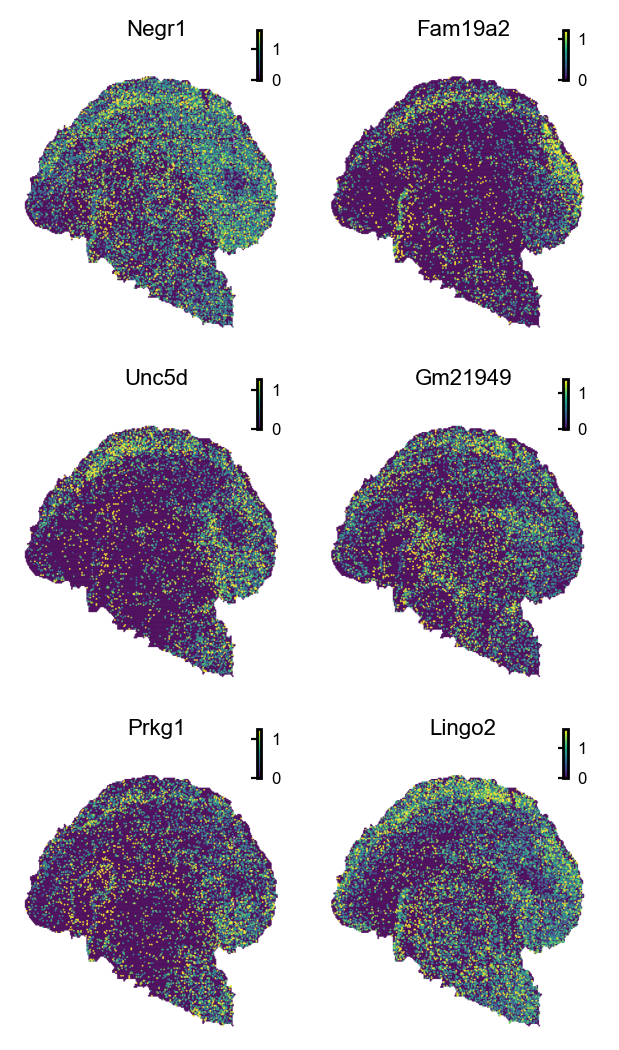

In [10]:
# Visualize column-variable genes
adata_bin30.X = adata_bin30.layers['count'].copy()
dyn.pp.normalize_cell_expr_by_size_factors(adata_bin30)
st.pl.space(
    adata_bin30,
    genes=df.loc[np.logical_and(df['pval']<0.05, df['pos_rate']>0.2),:].index.to_list()[0:6],
    ncols=2,
    pointsize=0.02,
    figsize=(2, 2),
    cmap="viridis",
    show_legend="upper left",
    save_show_or_return='show', save_kwargs={"path":"./figures/EX_glm_deg", "ext":"pdf", "dpi":800})